We certify that the code and data in this assignment were generated independently, using only the tools and resources defined in the course and that I/we did not receive any external help, coaching or contributions during the production of this work.

# Assignment 2 - Team 16
---

## Part III - Improving DQN & Solving OpenAI Gym Environment

### Implementing `LunarLander-v2`

LunarLander-v2 at a glance

In [1]:
import gym
import numpy as np
import random
from random import sample
import torch
import torch.nn as nn
from collections import deque
import time

In [2]:
env = gym.make('LunarLander-v2')

In [3]:
env.observation_space

Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)

In [4]:
env.action_space.n

4

In [5]:
help(env.unwrapped)

Help on LunarLander in module gym.envs.box2d.lunar_lander object:

class LunarLander(gym.core.Env, gym.utils.ezpickle.EzPickle)
 |  Method resolution order:
 |      LunarLander
 |      gym.core.Env
 |      gym.utils.ezpickle.EzPickle
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  close(self)
 |      Override close in your subclass to perform any necessary cleanup.
 |      
 |      Environments will automatically close() themselves when
 |      garbage collected or when the program exits.
 |  
 |  render(self, mode='human')
 |      Renders the environment.
 |      
 |      The set of supported modes varies per environment. (And some
 |      environments do not support rendering at all.) By convention,
 |      if mode is:
 |      
 |      - human: render to the current display or terminal and
 |        return nothing. Usually for human consumption.
 |      - rgb_array: Return a

Implementing `LunarLander-v2` using DQN
What are different from the DQN in the Part II?
- 1. We synchronize the two networks (the Q-network and the Target Network) using soft update for some steps to improve the performance of our DQN model while we followed the original DQN's method which adopted synchronization of two networks for some episodes and it was not soft update. As a result, it proves that adopting soft update is the most decisive factor to improve the performance of the algorithm.
- 2. It samples data from the Replay Buffer and update the model for some steps whereas the DQN in the part II does for some episodes. We have tried for several time the same as we have done in the 3.1. However, we have failed to attain a score more than 200. Therefore, we decided to do for a couple of steps.
- 3. We compute moving averages scores as well as scores (total rewards) for every episode. This is because we need a model that can stably complete the mission.
- 4. We need more computational resources since the burden added by applying the measures from '1' to '3' has drastically increased. Thus, we decided to use 'cuda' device.

In [6]:
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0
        
    def push(self, experience):
        self.buffer[self.index] = experience
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size
        
    def sample(self, batch_size):
        indices = sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]
        
    def __len__(self):
        return self.size

In [7]:
def _to_device(sample, device):
    states = []
    actions = []
    rewards = []
    next_states = []
    dones = []
    
    for i in sample:
        states.append(i[0])
        actions.append(i[1])
        rewards.append(i[2])
        next_states.append(i[3])
        dones.append(i[4])
    
    states = torch.cat(states, dim = 0).float().to(device)
    actions = torch.cat(actions, dim = 0).to(device)
    rewards = torch.cat(rewards, dim = 0).float().to(device)
    next_states = torch.cat(next_states, dim = 0).float().to(device)
    dones = torch.cat(dones, dim = 0).float().to(device)
    
    return states, actions, rewards, next_states, dones

In [8]:
class QLearner(nn.Module):
    def __init__(self,
                 input_dim: int,
                 output_dim: int,
                 num_neurons: list,
                 hidden_activation: str = 'ReLU',
                 out_activation: str = 'Identity'):
        super(QLearner, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_neurons = num_neurons
        self.hidden_activation = getattr(nn, hidden_activation)()
        self.out_activation = getattr(nn, out_activation)()
        
        input_dims = [input_dim] + num_neurons
        output_dims = num_neurons + [output_dim]

        self.layers = nn.ModuleList()
        for i, (in_dim, out_dim) in enumerate(zip(input_dims, output_dims)):
            is_last = True if i == len(input_dims) - 1 else False
            self.layers.append(nn.Linear(in_dim, out_dim))
            if is_last:
                self.layers.append(self.out_activation)
            else:
                self.layers.append(self.hidden_activation)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
class DQN(nn.Module):
    def __init__(self,
                 state_space: int,
                 action_space: int,
                 q_network: nn.Module,
                 target_network: nn.Module,
                 lr: float,
                 gamma: float,
                 eps: float):
        """
        state_space: input state dimension
        action_space: input action dimension
        q_network: main Q-network
        target_network: Target Q-network
        lr: learning rate
        gamma: discount factor
        eps: epsilon-greedy factor
        """
        
        super(DQN, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.q_network = q_network.to(device)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.optimizer = torch.optim.Adam(
            params = self.q_network.parameters(), lr = lr)
        self.register_buffer('epsilon', torch.ones(1) * eps)
        self.target_network = target_network.to(device)
        self.criteria = nn.MSELoss()
        
    def get_action(self, state):
        state = state.to(device)
        prob = np.random.uniform(0.0, 1.0, 1)
        if torch.from_numpy(prob).float() <= self.eps:
            return int(np.random.choice(range(self.action_space)))
        else:
            return int(self.q_network(state).argmax(dim = -1))
    
    def update(self, state, action, reward, next_state, done):
        with torch.no_grad():
            max_q, _ = self.target_network(next_state).max(dim = -1, keepdims = True)
            q_target = reward + self.gamma * max_q * (1 - done)
        q_val = self.q_network(state).gather(1, action)
        loss = self.criteria(q_val, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
num_episodes = 2000

lr = 0.002
gamma = 0.99
eps = 1.0
eps_decaying = (0.01 / eps)**(1 / num_episodes)
interval = 5
memory_size = 10000
batch_size = 64
seed = 0

In [12]:
env = gym.make('LunarLander-v2')
env.seed(seed)

[0]

In [13]:
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

num_neurons = [64, 64]
q_network = QLearner(input_dim = state_space,
                     output_dim = action_space,
                     num_neurons = num_neurons)
target_network = QLearner(input_dim = state_space,
                          output_dim = action_space,
                          num_neurons = num_neurons)

In [14]:
dqn = DQN(state_space,
          action_space,
          q_network = q_network,
          target_network = target_network,
          lr = lr,
          gamma = gamma,
          eps = eps)
memory = ReplayBuffer(memory_size)

In [15]:
def to_tensor(np_array: np.array, size = None) -> torch.tensor:
    torch_tensor = torch.from_numpy(np_array).float()
    if size is not None:
        torch_tensor = torch_tensor.view(size)
    return torch_tensor

In [16]:
start = time.time()

max_steps = 1000
tau = 1e-3
scores = []
# to compute the moving average of the latest 100 episodes
scores_window = deque(maxlen = 100)

epsilon = []
print_every = 100

for ep in range(num_episodes):

    dqn.eps = torch.tensor(eps)
    state = env.reset()
    total_reward = 0

    for step in range(max_steps):
        
        state = to_tensor(state, (1, state_space))
        action = dqn.get_action(state)
        next_state, reward, done, _ = env.step(action)

        experience = (state,
                      torch.tensor(action).view(1, 1),
                      torch.tensor(reward).view(1, 1),
                      torch.tensor(next_state).view(1, state_space),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        state = next_state
        total_reward += reward
        
        if step % interval == 0:
            if len(memory) >= batch_size:
                sampled = memory.sample(batch_size)
                sampled = _to_device(sampled, device)
                dqn.update(*sampled)

            for target_params, q_params in zip(target_network.parameters(),
                                               q_network.parameters()):
                target_params.data.copy_(tau * q_params.data + (1.0 - tau) * target_params.data)

        if done:
            break

    scores.append(total_reward)
    scores_window.append(total_reward)
    epsilon.append(eps)

    eps = eps * eps_decaying
        
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1:4.0f}\t| "
              + f"Score: {total_reward:3.2f}\t| "
              + f"Avg Score: {np.mean(scores_window):3.2f}\t| "
              + f"Eps: {eps:.3f}")
    
    # Note that the game is solved if we get more than 200.
    # The average is calculated to determine if a model (estimates for
    # the parameters) can stably exceed 200.
    if np.mean(scores_window) >= 200.0:
        print(f"LunarLander-v2 solved in the {ep + 1}th episode." +
              f"\tAvg Score: {np.mean(scores_window):3.2f}")
        # Save the model.
        torch.save(dqn.q_network.state_dict(), "dqn_for_ll-v2.pth")
        break

end = time.time()
print("The time of execution of the DQN algorithm is: ", end - start)

Episode:    0	| Score: -130.00	| Avg Score: -130.00	| Eps: 0.998
Episode:  100	| Score: -195.86	| Avg Score: -169.04	| Eps: 0.793
Episode:  200	| Score: -78.65	| Avg Score: -138.04	| Eps: 0.630
Episode:  300	| Score: 112.72	| Avg Score: -84.76	| Eps: 0.500
Episode:  400	| Score: 30.74	| Avg Score: -44.74	| Eps: 0.397
Episode:  500	| Score: 25.53	| Avg Score: -5.39	| Eps: 0.316
Episode:  600	| Score: 38.04	| Avg Score: 53.82	| Eps: 0.251
Episode:  700	| Score: 250.46	| Avg Score: 61.27	| Eps: 0.199
Episode:  800	| Score: 231.31	| Avg Score: 147.20	| Eps: 0.158
Episode:  900	| Score: 228.20	| Avg Score: 178.14	| Eps: 0.126
LunarLander-v2 solved in the 941th episode.	Avg Score: 200.66
The time of execution of the DQN algorithm is:  664.936776638031


In [17]:
import matplotlib.pyplot as plt

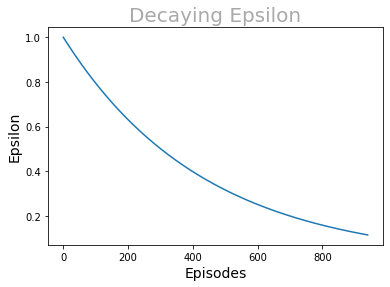

In [18]:
# the plot for epsilons
fig, ax = plt.subplots()
ax.plot(epsilon)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Epsilon", color = "black", fontsize = 14)
plt.title('Decaying Epsilon', color = "darkgrey", fontsize = 20)
plt.show()

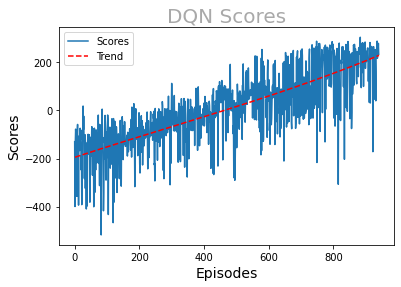

In [140]:
# the plot for rewards
x = np.arange(941) + 1
y = np.array(scores)
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(scores)
ax.plot(x, p(x), 'r--')
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Scores", color = "black", fontsize = 14)
plt.title('DQN Scores', color = "darkgrey", fontsize = 20)
plt.legend(['Scores', 'Trend'])
plt.show()

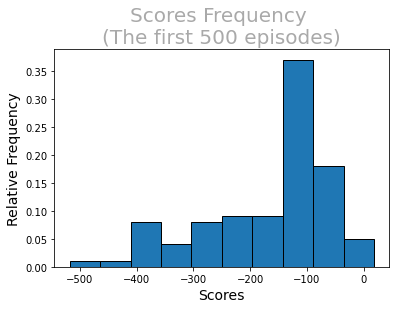

In [53]:
# Plot a relative frequency
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(scores[:100], edgecolor = 'black',
        weights = np.ones_like(scores[:100]) /
        len(scores[:100]))
ax.set_xlabel("Scores", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Scores Frequency \n(The first 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

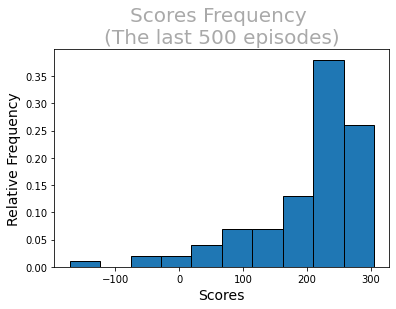

In [54]:
# Plot a relative frequency for the last 1000 episodes
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(scores[-100:], edgecolor = 'black',
        weights = np.ones_like(scores[-100:]) /
        len(scores[-100:]))
ax.set_xlabel("Scores", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Scores Frequency \n(The last 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

For video encoding and playing, we refer to the following online manual.

IPython Documentation: https://ipython.readthedocs.io/en/stable/index.html

In [22]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import glob
from base64 import b64encode
import io
from IPython.display import display
from IPython.display import HTML

In [109]:
def record_mp4(successful_case, env, set_seed, video_name):
    env.seed(set_seed) # the same seed as the one for which out model has been trained
    path = f"./video/{video_name}.mp4"
    video = VideoRecorder(env, path)
    state = env.reset()
    while True:
        frame = env.render(mode = 'rgb_array')
        video.capture_frame()
        state = to_tensor(state, size = (1, state_space))
        action = successful_case.get_action(state)
        state, reward, done, _ = env.step(action)
        if done:
            video.close()
            break
    env.close()

def render_mp4(video_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4_path = f"video/{video_name}.mp4"
        mp4 = io.open(mp4_path, 'r+b').read()
        base64_encoded_mp4 = b64encode(mp4).decode('ascii')
        display(HTML(data = f'<video alt="test" autoplay loop' \
                            f'controls style="height: 400px;">' \
                            f'<source src="data:video/mp4;base64,' \
                            f'{base64_encoded_mp4}" ' \
                            f'type="video/mp4"></video>'))
    else:
        print("No video available")

In [110]:
# Q-network for overwriting the successful model previously saved
q_network_success = QLearner(input_dim = state_space,
                             output_dim = action_space,
                             num_neurons = num_neurons)
q_network_success.load_state_dict(torch.load('dqn_for_ll-v2.pth'))

<All keys matched successfully>

In [111]:
# DQN agent
eps = 0.0
dqn_success = DQN(state_space,
                  action_space,
                  q_network = q_network_success,
                  target_network = target_network,
                  lr = lr,
                  gamma = gamma,
                  eps = eps)

In [112]:
record_mp4(dqn_success, env, seed, 'LunarLander-v2 using DQN')

In [113]:
render_mp4('LunarLander-v2 using DQN')

Implementing `LunarLander-v2` using Double DQN

What are different from the Double DQN in 3.2?

(almost the same differences as the case of the DQN)
- 1. We synchronize the two networks (the Q-network and the Target Network) using soft update for some steps to improve the performance of our Double DQN model while we followed the original Double DQN's method which adopted synchronization of two networks for some episodes and it was not soft update. As a result, it proves that adopting soft update is the most decisive factor to improve the performance of the algorithm.
- 2. It samples data from the Replay Buffer and update the model for some steps whereas the Double DQN in the 3.1 does for some episodes. We have tried for several time the same as we have done in the 3.1. However, we have failed to attain a score more than 200. Therefore, we decided to do for a couple of steps.
- 3. We compute moving averages scores as well as scores (total rewards) for every episode. This is because we need a model that can stably complete the mission.
- 4. We need more computational resources since the burden added by applying the measures from '1' to '3' has drastically increased. Thus, we decided to use 'cuda' device.

In [28]:
class DoubleDQN(nn.Module):
    def __init__(self,
                 state_space: int,
                 action_space: int,
                 q_network: nn.Module,
                 target_network: nn.Module,
                 lr: float,
                 gamma: float,
                 eps: float):
        """
        state_space: input state dimension
        action_space: input action dimension
        q_network: main Q-network
        target_network: Target Q-network
        lr: learning rate
        gamma: discount factor
        eps: epsilon-greedy factor
        """
        
        super(DoubleDQN, self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.q_network = q_network.to(device)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.optimizer = torch.optim.Adam(
            params = self.q_network.parameters(), lr = lr)
        self.register_buffer('epsilon', torch.ones(1) * eps)
        self.target_network = target_network.to(device)
        self.criteria = nn.MSELoss()
        
    def get_action(self, state):
        state = state.to(device)
        prob = np.random.uniform(0.0, 1.0, 1)
        if torch.from_numpy(prob).float() <= self.eps:
            return int(np.random.choice(range(self.action_space)))
        else:
            return int(self.q_network(state).argmax(dim = -1))
    
    def update(self, state, action, reward, next_state, done):
        with torch.no_grad():
            greedy_action = self.q_network(next_state).argmax(dim = -1)
            greedy_action = greedy_action[:, None]
            doubledqn_q_max = self.target_network(next_state).gather(1, greedy_action)
            q_target = reward + self.gamma * doubledqn_q_max * (1 - done)
        q_val = self.q_network(state).gather(1, action)
        loss = self.criteria(q_val, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

In [29]:
num_episodes = 2000

lr = 0.002
gamma = 0.99
eps = 1.0
eps_decaying = (0.01 / eps)**(1 / num_episodes)
interval = 5
memory_size = 10000
batch_size = 64
seed_double = 0

In [30]:
env_double = gym.make('LunarLander-v2')
env.seed(seed_double)

[0]

In [31]:
num_neurons = [64, 64]
q_network_double = QLearner(input_dim = state_space,
                            output_dim = action_space,
                            num_neurons = num_neurons)
target_network_double = QLearner(input_dim = state_space,
                                 output_dim = action_space,
                                 num_neurons = num_neurons)

In [32]:
doubledqn = DoubleDQN(state_space,
                      action_space,
                      q_network = q_network_double,
                      target_network = target_network_double,
                      lr = lr,
                      gamma = gamma,
                      eps = eps)
memory = ReplayBuffer(memory_size)

In [33]:
start = time.time()

max_steps_double = 1000
tau = 1e-3
scores_double = []
# to compute the moving average of the latest 100 episodes
scores_window_double = deque(maxlen = 100)

epsilon_double = []
print_every = 100

for ep in range(num_episodes):

    doubledqn.eps = torch.tensor(eps)
    state = env.reset()
    total_reward_double = 0

    for step in range(max_steps_double):
        
        state = to_tensor(state, size = (1, state_space))
        action = doubledqn.get_action(state)
        next_state, reward, done, _ = env.step(action)

        experience = (state,
                      torch.tensor(action).view(1, 1),
                      torch.tensor(reward).view(1, 1),
                      torch.tensor(next_state).view(1, state_space),
                      torch.tensor(done).view(1, 1))
        memory.push(experience)

        state = next_state
        total_reward_double += reward
        
        if step % interval == 0:
            if len(memory) >= batch_size:
                sampled = memory.sample(batch_size)
                sampled = _to_device(sampled, device)
                doubledqn.update(*sampled)

            for target_params, q_params in zip(target_network_double.parameters(),
                                               q_network_double.parameters()):
                target_params.data.copy_(tau * q_params.data + (1.0 - tau) * target_params.data)
            
        if done:
            break

    scores_double.append(total_reward_double)
    scores_window_double.append(total_reward_double)
    epsilon_double.append(eps)

    eps = eps * eps_decaying
        
    if ep % print_every == (print_every - 1):
        print(f"Episode: {ep + 1:4.0f}\t| "
              + f"Score: {total_reward_double:3.2f}\t| "
              + f"Avg Score: {np.mean(scores_window_double):3.2f}\t| "
              + f"Eps: {eps:.3f}")
    
    if np.mean(scores_window_double) >= 200.0:
        print(f"LunarLander-v2 solved in the {ep + 1}th episode." +
              f"\tAvg Score: {np.mean(scores_window_double):3.2f}")
        torch.save(doubledqn.q_network.state_dict(), "doubledqn_for_ll-v2.pth")
        break

end = time.time()
print("The time of execution of the Double DQN algorithm is: ", end - start)

Episode:    0	| Score: -13.39	| Avg Score: -13.39	| Eps: 0.998
Episode:  100	| Score: -131.62	| Avg Score: -166.80	| Eps: 0.793
Episode:  200	| Score: -140.10	| Avg Score: -144.90	| Eps: 0.630
Episode:  300	| Score: -11.14	| Avg Score: -87.25	| Eps: 0.500
Episode:  400	| Score: -16.17	| Avg Score: -76.42	| Eps: 0.397
Episode:  500	| Score: -49.20	| Avg Score: 1.05	| Eps: 0.316
Episode:  600	| Score: 218.95	| Avg Score: 58.19	| Eps: 0.251
Episode:  700	| Score: -75.85	| Avg Score: 52.08	| Eps: 0.199
Episode:  800	| Score: -4.20	| Avg Score: 138.65	| Eps: 0.158
Episode:  900	| Score: 243.29	| Avg Score: 198.46	| Eps: 0.126
LunarLander-v2 solved in the 902th episode.	Avg Score: 200.77
The time of execution of the Double DQN algorithm is:  577.9678082466125


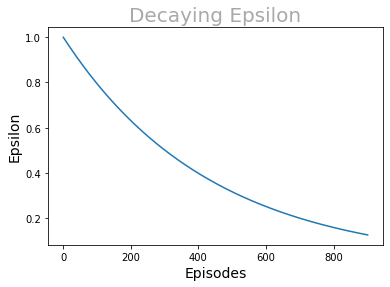

In [34]:
# the plot for epsilons
fig, ax = plt.subplots()
ax.plot(epsilon_double)
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Epsilon", color = "black", fontsize = 14)
plt.title('Decaying Epsilon', color = "darkgrey", fontsize = 20)
plt.show()

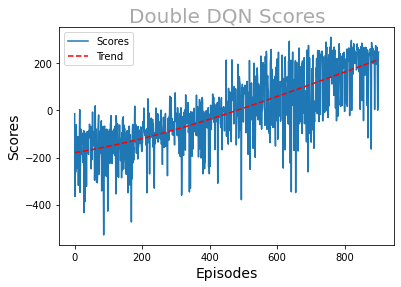

In [138]:
# the plot for rewards
x = np.arange(902) + 1
y = np.array(scores_double)
z = np.polyfit(x, y, 3)
p = np.poly1d(z)

fig, ax = plt.subplots(figsize = (6, 4), sharex = True, sharey = True)
ax.plot(scores_double)
ax.plot(x, p(x), 'r--')
ax.set_xlabel("Episodes", fontsize = 14)
ax.set_ylabel("Scores", color = "black", fontsize = 14)
plt.title('Double DQN Scores', color = "darkgrey", fontsize = 20)
plt.legend(['Scores', 'Trend'])
plt.show()

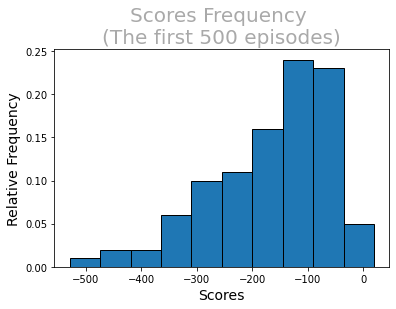

In [44]:
# Plot a relative frequency
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(scores_double[:100], edgecolor = 'black',
        weights = np.ones_like(scores_double[:100]) /
        len(scores_double[:100]))
ax.set_xlabel("Scores", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Scores Frequency \n(The first 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

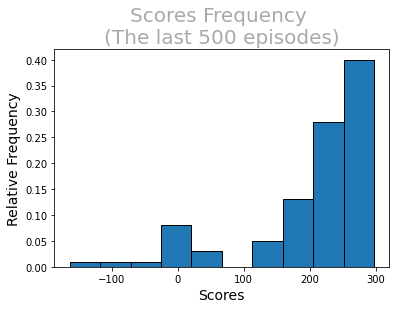

In [45]:
# Plot a relative frequency for the last 1000 episodes
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(scores_double[-100:], edgecolor = 'black',
        weights = np.ones_like(scores_double[-100:]) /
        len(scores_double[-100:]))
ax.set_xlabel("Scores", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Scores Frequency \n(The last 500 episodes)', color = "darkgrey", fontsize = 20)
plt.show()

In [38]:
# Q-network for overwriting the successful model previously saved
q_network_double_success = QLearner(input_dim = state_space,
                                    output_dim = action_space,
                                    num_neurons = num_neurons)
q_network_double_success.load_state_dict(torch.load('doubledqn_for_ll-v2.pth'))

<All keys matched successfully>

In [39]:
# Double DQN agent
eps = 0.0
doubledqn_success = DoubleDQN(state_space,
                              action_space,
                              q_network = q_network_double_success,
                              target_network = target_network_double,
                              lr = lr,
                              gamma = gamma,
                              eps = eps)

In [77]:
record_mp4(doubledqn_success, env_double, seed_double, 'LunarLander-v2 using Double DQN')

In [78]:
render_mp4('LunarLander-v2 using Double DQN')

In [42]:
import pandas as pd

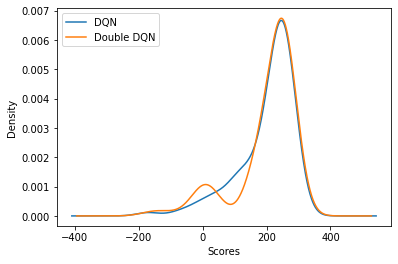

In [86]:
fig, ax = plt.subplots(1, 1)
_ = pd.Series(scores[-100:], name = "Score (DQN)").plot(kind = "kde", ax = ax, label = "DQN")
_ = pd.Series(scores_double[-100:], name = "Score (Double DQN)").plot(kind = "kde", ax = ax, label = "Double DQN")
_ = ax.set_xlabel("Scores")
_ = ax.legend()

Evaluating performance using the seed, 0

In [114]:
dqn_scores_0 = []

env.seed(0)
for _ in range(10):
    score = 0
    state = env.reset()
    while True:
        state = to_tensor(state, size = (1, state_space))
        action = dqn_success.get_action(state)
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            break
    dqn_scores_0.append(score)
    
doubledqn_scores_0 = []

env_double.seed(0)
for _ in range(10):
    score = 0
    state = env_double.reset()
    while True:
        state = to_tensor(state, size = (1, state_space))
        action = doubledqn_success.get_action(state)
        state, reward, done, _ = env_double.step(action)
        score += reward
        if done:
            break
    doubledqn_scores_0.append(score)

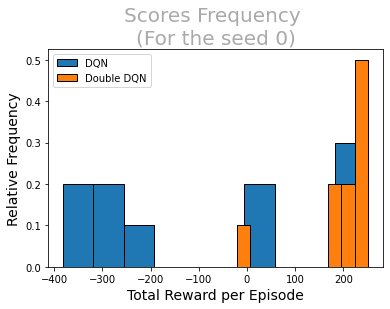

In [120]:
# Plot a relative frequency for the last 1000 episodes
fig = plt.figure(figsize = (6, 4))
ax = fig.add_subplot(111)
ax.hist(dqn_scores_0, edgecolor = 'black',
        weights = np.ones_like(dqn_scores_0) /
        len(dqn_scores_0))
ax.hist(doubledqn_scores_0, edgecolor = 'black',
        weights = np.ones_like(dqn_scores_0) /
        len(dqn_scores_0))
ax.set_xlabel("Total Reward per Episode", fontsize = 14)
ax.set_ylabel("Relative Frequency", color = "black", fontsize = 14)
plt.title('Scores Frequency \n(For the seed 0)', color = "darkgrey", fontsize = 20)
plt.legend(['DQN', 'Double DQN'])
plt.show()

Evaluating performance using seeds which have not been applied

(That is, except for the seed 0)

In [102]:
dqn_scores = []
print_every = 100

# Seeds from 1 to 1000 are appplied.
# The seed 0 which has already been applied is excluded.
for seed in range(1000):
    env.seed(seed + 1)
    score = 0
    state = env.reset()
    while True:
        state = to_tensor(state, size = (1, state_space))
        action = dqn_success.get_action(state)
        state, reward, done, _ = env.step(action)
        score += reward
        if done:
            break
    dqn_scores.append(score)
    if seed % print_every == (print_every - 1):
        print(f"{seed + 1} seeds executed.")

100 seeds executed.
200 seeds executed.
300 seeds executed.
400 seeds executed.
500 seeds executed.
600 seeds executed.
700 seeds executed.
800 seeds executed.
900 seeds executed.
1000 seeds executed.


In [103]:
doubledqn_scores = []
print_every = 100

for seed in range(1000):
    env_double.seed(seed + 1)
    score = 0
    state = env_double.reset()
    while True:
        state = to_tensor(state, size = (1, state_space))
        action = doubledqn_success.get_action(state)
        state, reward, done, _ = env_double.step(action)
        score += reward
        if done:
            break
    doubledqn_scores.append(score)
    if seed % print_every == (print_every - 1):
        print(f"{seed + 1} seeds executed.")

100 seeds executed.
200 seeds executed.
300 seeds executed.
400 seeds executed.
500 seeds executed.
600 seeds executed.
700 seeds executed.
800 seeds executed.
900 seeds executed.
1000 seeds executed.


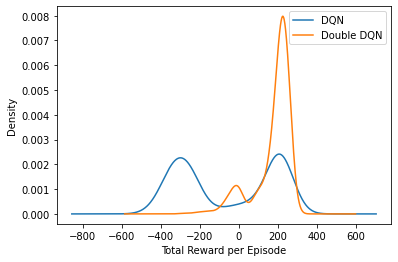

In [121]:
# 1000 trials for randomly chosen seeds
fig, ax = plt.subplots(1, 1)
_ = pd.Series(dqn_scores, name = "Score (DQN)").plot(kind = "kde", ax = ax, label = "DQN")
_ = pd.Series(doubledqn_scores, name = "Score (Double DQN)").plot(kind = "kde", ax = ax, label = "Double DQN")
_ = ax.set_xlabel("Total Reward per Episode")
_ = ax.legend()